In [39]:
import re
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import string
import keras
import nltk
import gensim
import spacy
from nltk.corpus import wordnet
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [40]:
twitter = pd.read_csv('Mental-Health-Twitter.csv')

In [41]:
twitter.shape

(20000, 11)

In [42]:
twitter.reset_index(drop=True,inplace=True)
twitter_df = twitter[['post_text']]

In [43]:
twitter_df.head()

,post_text
0,It's just over 2 years since I was diagnosed w...
1,"It's Sunday, I need a break, so I'm planning t..."
2,Awake but tired. I need to sleep but my brain ...
3,RT @SewHQ: #Retro bears make perfect gifts and...
4,It’s hard to say whether packing lists are mak...


In [44]:
twitter_df.isnull().sum()

post_text    0
dtype: int64

Data Preprocessing 

In [14]:
#Removing URLs 

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

for i in range(len(twitter_df)):
  twitter_df.at[i,'post_text'] = remove_urls(twitter_df.iloc[i]['post_text'])
twitter_df.head()

,post_text
0,It's just over 2 years since I was diagnosed w...
1,"It's Sunday, I need a break, so I'm planning t..."
2,Awake but tired. I need to sleep but my brain ...
3,RT @SewHQ: #Retro bears make perfect gifts and...
4,It’s hard to say whether packing lists are mak...


In [15]:
# Creating a list using the twitter dataset
twitterData = twitter_df['post_text'].values.tolist()

# Removing all emails
data = [re.sub('\S*@\S*\s?', '', s) for s in twitterData]

# Removing the new line characters
data = [re.sub('\s+', ' ', s) for s in twitterData]

# Also removing the unnecessary single quotes
data = [re.sub("\'", "", s) for s in twitterData]

print(data[:1])

['Its just over 2 years since I was diagnosed with #anxiety and #depression. Today Im taking a moment to reflect on how far Ive come since.']


In [16]:
def newWords(sentence):
    for sentence in sentence:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # removing the punctuations

new_words = list(newWords(twitterData))

print(new_words[:1])

[['it', 'just', 'over', 'years', 'since', 'was', 'diagnosed', 'with', 'anxiety', 'and', 'depression', 'today', 'taking', 'moment', 'to', 'reflect', 'on', 'how', 'far', 've', 'come', 'since']]


In [17]:
# ngram models - bigram and trigram
bigram = gensim.models.Phrases(new_words, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[new_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# display a trigram
print(trigram_mod[bigram_mod[new_words[0]]])

['it', 'just', 'over', 'years', 'since', 'was', 'diagnosed', 'with', 'anxiety', 'and', 'depression', 'today', 'taking', 'moment', 'to', 'reflect', 'on', 'how', 'far', 've', 'come', 'since']


In [21]:
# stopwords, bigrams, trigrams and lemmatization functions
from nltk.corpus import stopwords
nltk.download('stopwords')
stopWords = set(stopwords.words("english"))


def removeStopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for s in texts:
        doc = nlp(" ".join(s)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
# Stop words are removed
noStopWords = removeStopwords(new_words)

# Bigrams
new_words_bigrams = bigrams(noStopWords)

# spacy 'en' model with tagger component 

nlp = spacy.load("en_core_web_sm")

# lemmatization
lemmatized_data = lemmatization(new_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(lemmatized_data[:1])

[['year', 'diagnose', 'anxiety', 'depression', 'today', 'take', 'moment', 'reflect', 'far', 'come', 'since']]


In [45]:
twitter_df = []
for i in range(len(lemmatized_data)):
    twitter_df.append(" ".join(lemmatized_data[i]))
twitter_df = pd.Series(twitter_df)

DATA VECTORIZATION

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
numFeatures = 15000
tf_vectorizer = CountVectorizer(max_df=0.95,max_features=numFeatures)
tf = tf_vectorizer.fit_transform(twitter_df)
tf_feature_names = tf_vectorizer.get_feature_names()

In [36]:
from sklearn.decomposition import LatentDirichletAllocation
numTopics = 2
lda = LatentDirichletAllocation(n_components=numTopics, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

In [48]:
# Document:Topic Matrix is created
lda_output = lda.transform(tf)
# naming columns
topicnames = ['Topic' + str(i) for i in range(lda.n_components)]
# naming index
docnames = ['Doc' + str(i) for i in range(len(twitter_df))]
# pandas df
df_main_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get main topic for each document
main_topic = np.argmax(df_main_topic.values, axis=1)
df_main_topic['main_topic'] = main_topic

df_main_topics = df_main_topic
twitter_df1 = pd.read_csv('Mental-Health-Twitter.csv')
df_main_topics.reset_index(inplace=True,drop=True)
twitter_df1['label'] = df_main_topics['main_topic']

In [50]:
twitter_df = twitter_df1[['post_text','label']]
twitter_df.head()

,post_text,label
0,It's just over 2 years since I was diagnosed w...,1
1,"It's Sunday, I need a break, so I'm planning t...",1
2,Awake but tired. I need to sleep but my brain ...,1
3,RT @SewHQ: #Retro bears make perfect gifts and...,0
4,It’s hard to say whether packing lists are mak...,1


In [51]:
twitter_df[twitter_df1['label']==1]

,post_text,label
0,It's just over 2 years since I was diagnosed w...,1
1,"It's Sunday, I need a break, so I'm planning t...",1
2,Awake but tired. I need to sleep but my brain ...,1
4,It’s hard to say whether packing lists are mak...,1
5,Making packing lists is my new hobby... #movin...,1
...,...,...
19992,"After winning the pennant one year, Casey Sten...",1
19994,You will have good luck and overcome many hard...,1
19995,A day without sunshine is like night.,1
19998,"Ships are safe in harbor, but they were never ...",1


In [52]:
for i in range(10):
    print(twitter_df[twitter_df['label']==1].iloc[i][0])
    print('\n')

It's just over 2 years since I was diagnosed with #anxiety and #depression. Today I'm taking a moment to reflect on how far I've come since.


It's Sunday, I need a break, so I'm planning to spend as little time as possible on the #A14...


Awake but tired. I need to sleep but my brain has other ideas...


It’s hard to say whether packing lists are making life easier or just reinforcing how much still needs doing... #movinghouse #anxiety


Making packing lists is my new hobby... #movinghouse


At what point does keeping stuff for nostalgic reasons cross the line into plain old hoarding...? #movinghouse


Can't be bothered to cook, take away on the way 😁👍🏼 #lazy


RT @itventsnews: ITV releases promo video for the final series of Downton Abbey http://t.co/mC8Ive72zR http://t.co/CFBKrRvJIs


... also, I have too much stuff. Way, way too much #movinghouse


I never want to put one of these together again #lotharderthanitlooks http://t.co/70ujlTCKlB




In [54]:
for i in range(len(twitter_df)):
  twitter_df.at[i,'post_text'] = remove_urls(twitter_df.iloc[i]['post_text'])
twitter_df.head()

,post_text,label
0,It's just over 2 years since I was diagnosed w...,1
1,"It's Sunday, I need a break, so I'm planning t...",1
2,Awake but tired. I need to sleep but my brain ...,1
3,RT @SewHQ: #Retro bears make perfect gifts and...,0
4,It’s hard to say whether packing lists are mak...,1


In [55]:
twitter_data = twitter_df['post_text'].values.tolist()
twitter_data = [re.sub('\S*@\S*\s?', '', w) for w in data]
twitter_data = [re.sub('\s+', ' ', w) for w in data]
twitter_data = [re.sub("\'", "", w) for w in data]
twitter_data = [re.sub(",", "", w) for w in data]
twitter_data = [w.lower() for w in data]

# extra dots removed
data = [w.replace('.', '') for w in data]

print(data[:1])

['Its just over 2 years since I was diagnosed with #anxiety and #depression Today Im taking a moment to reflect on how far Ive come since']


In [86]:
allTweets = np.array(data)
labels = np.array(twitter_df['label'])

In [87]:
print(len(allTweets),len(labels))

20000 20000


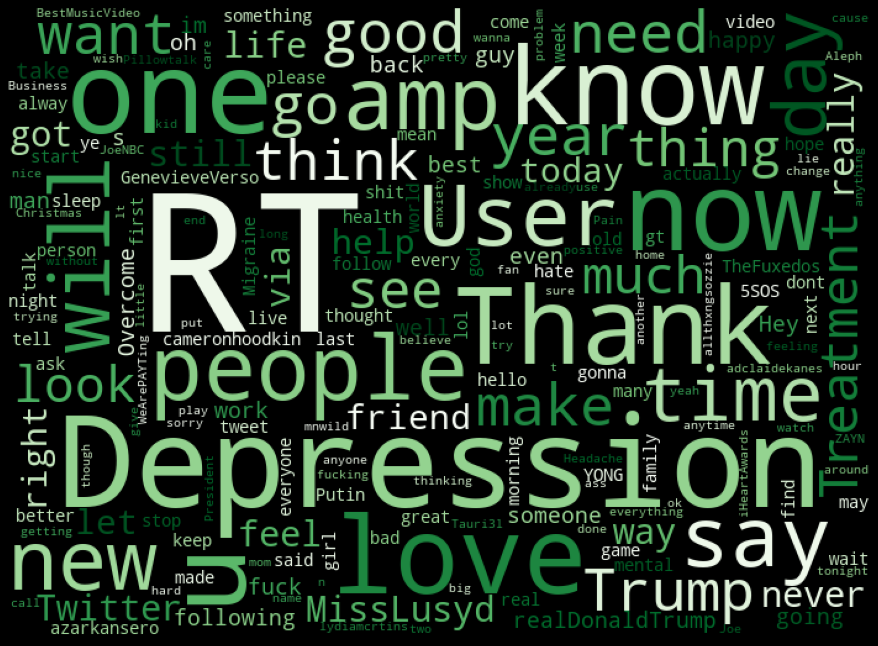

In [82]:
from wordcloud import WordCloud
t = [x for x in twitter_df['post_text']]
w = ''.join(list(map(str,t)))
tweets_wc = WordCloud(width=700,height=512,collocations=False,colormap="Greens").generate(w)
plt.figure(figsize=(12, 10),facecolor='k')
plt.imshow(tweets_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

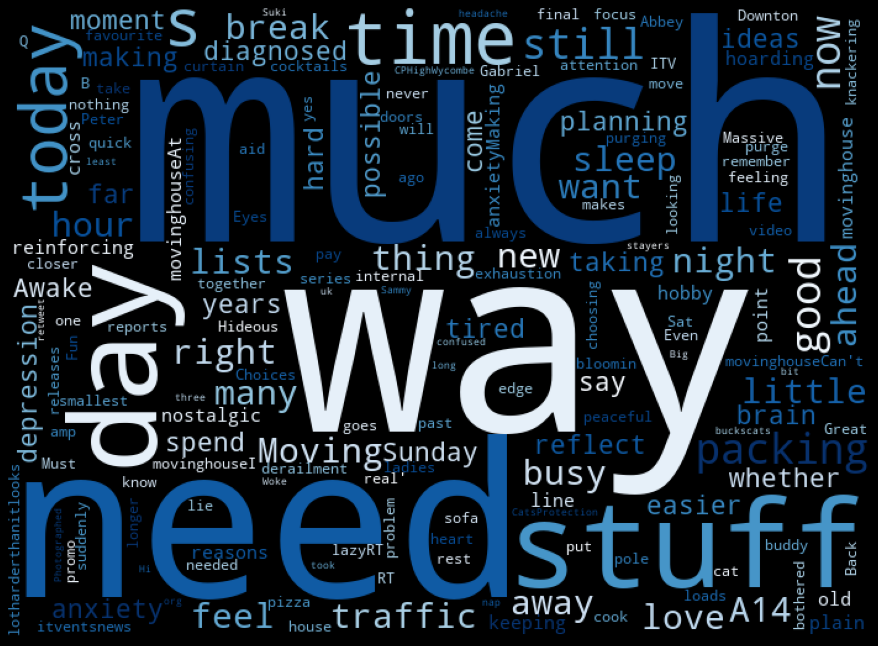

In [84]:
t=[]
a=[]
from wordcloud import WordCloud
for i in range(30):
  t=twitter_df[twitter_df['label']==1].iloc[i][0]
  a.insert(i,t)
w = ''.join(list(map(str,a)))
wc = WordCloud(width=700,height=512,collocations=False,colormap="Blues").generate(w)
plt.figure(figsize=(12, 10),facecolor='k')
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

BUILDING AND TRAINING THE MODEL



In [88]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers
maxWords = 20000
maxLength = 500

tokenizer = Tokenizer(num_words=maxWords)
tokenizer.fit_on_texts(allTweets)
sequences = tokenizer.texts_to_sequences(allTweets)
allTweets = pad_sequences(sequences, maxlen=maxLength)
print(allTweets)

[[   0    0    0 ...  112  187  278]
 [   0    0    0 ...   15    1 7728]
 [   0    0    0 ...   72  173 1185]
 ...
 [   0    0    0 ...    1  123  645]
 [   0    0    0 ...    3  391  113]
 [   0    0    0 ...    8   60 3309]]


In [89]:
X_train, X_test, y_train, y_test = train_test_split(allTweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

15000 5000 15000 5000


Model 1 - Basic RNN with single LSTM layer

In [ ]:
model1 = Sequential()
model1.add(layers.Embedding(maxWords, 50))
model1.add(layers.LSTM(50,dropout=0.5))
model1.add(layers.Dense(1,activation='sigmoid'))

model1.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

history = model1.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test))

Epoch 1/10
469/469 [==============================] - 153s 320ms/step - loss: 0.5763 - accuracy: 0.6908 - val_loss: 0.4954 - val_accuracy: 0.7548
Epoch 2/10
469/469 [==============================] - 163s 348ms/step - loss: 0.4015 - accuracy: 0.8169 - val_loss: 0.4344 - val_accuracy: 0.7998
Epoch 3/10
469/469 [==============================] - 160s 342ms/step - loss: 0.3270 - accuracy: 0.8587 - val_loss: 0.4105 - val_accuracy: 0.8136
Epoch 4/10
469/469 [==============================] - 158s 336ms/step - loss: 0.2800 - accuracy: 0.8821 - val_loss: 0.4070 - val_accuracy: 0.8222
Epoch 5/10
469/469 [==============================] - 157s 336ms/step - loss: 0.2535 - accuracy: 0.8963 - val_loss: 0.4070 - val_accuracy: 0.8290
Epoch 6/10
 91/469 [====>.........................] - ETA: 2:15 - loss: 0.2361 - accuracy: 0.9069

In [103]:
test_loss, test_acc = model1.evaluate(X_test,  y_test, verbose=2)
print('Model accuracy is = ',test_acc)

157/157 - 10s - loss: 0.4208 - accuracy: 0.8364 - 10s/epoch - 63ms/step
Model accuracy is =  0.8363999724388123


In [99]:
y_pred = model1.predict(X_test)

157/157 [==============================] - 11s 66ms/step


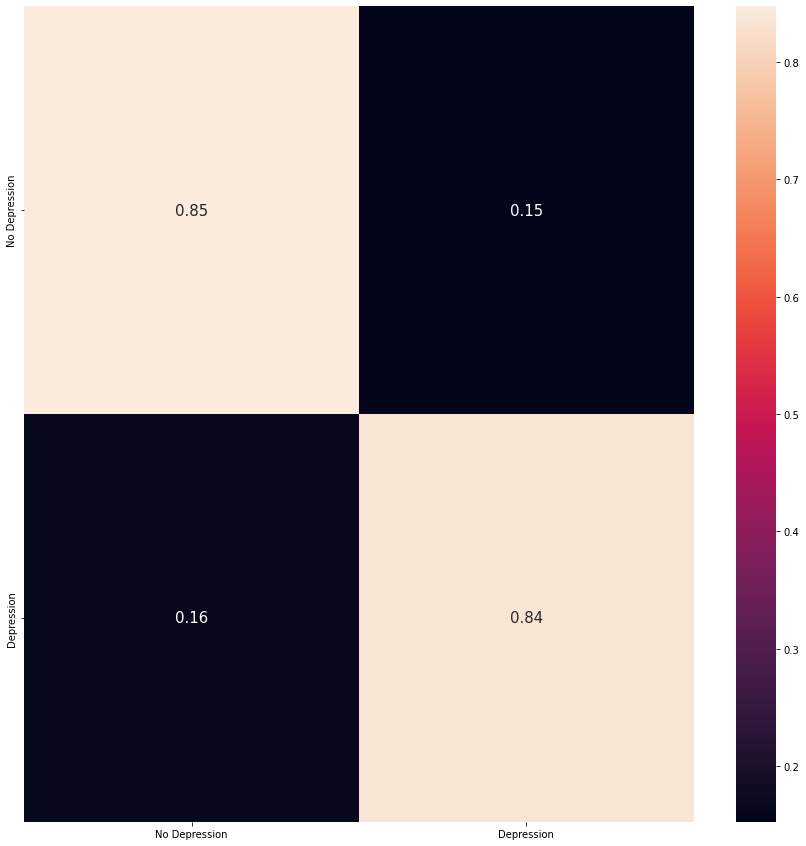

In [100]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
matrix = confusion_matrix(y_test, np.around(y_pred, decimals=0))
conf_matrix = pd.DataFrame(matrix, index = ['No Depression','Depression'],columns = ['No Depression','Depression'])
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [101]:
test = np.array(['I feel anxious lol'])
test_sequence = tokenizer.texts_to_sequences(test)
test_sequence = pad_sequences(test_sequence, maxlen=maxLength)
test_prediction = model1.predict(test_sequence)
if np.around(test_prediction, decimals=0)[0][0] == 1.0:
    print('The model predicted depressive/anxious language')
else:
    print("The model predicted other type of language")


1/1 [==============================] - 0s 48ms/step
The model predicted depressive/anxious language


Model 2 - Stacking LSTM layers and increasing the embedding dimension

In [ ]:
model2 = Sequential()
model2.add(layers.Embedding(maxWords, 40))
model2.add(layers.LSTM(40,dropout=0.5,return_sequences=True))
model2.add(layers.LSTM(40,dropout=0.5))
model2.add(layers.Dense(1,activation='sigmoid'))

model2.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

history = model2.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test))

Epoch 1/5
469/469 [==============================] - 282s 593ms/step - loss: 0.5956 - accuracy: 0.6691 - val_loss: 0.5483 - val_accuracy: 0.7032
Epoch 2/5
469/469 [==============================] - 280s 596ms/step - loss: 0.4253 - accuracy: 0.8015 - val_loss: 0.4340 - val_accuracy: 0.7954
Epoch 3/5
469/469 [==============================] - 247s 527ms/step - loss: 0.3420 - accuracy: 0.8492 - val_loss: 0.4159 - val_accuracy: 0.8112
Epoch 4/5
469/469 [==============================] - 257s 549ms/step - loss: 0.2937 - accuracy: 0.8769 - val_loss: 0.4046 - val_accuracy: 0.8220
Epoch 5/5
469/469 [==============================] - 254s 541ms/step - loss: 0.2652 - accuracy: 0.8899 - val_loss: 0.4055 - val_accuracy: 0.8296


In [ ]:
test_loss, test_acc = model2.evaluate(X_test,  y_test, verbose=2)
print('Model accuracy: ',test_acc)

157/157 - 14s - loss: 0.4055 - accuracy: 0.8296 - 14s/epoch - 87ms/step
Model accuracy:  0.8295999765396118


In [ ]:
y_pred = model2.predict(X_test)

157/157 [==============================] - 18s 110ms/step


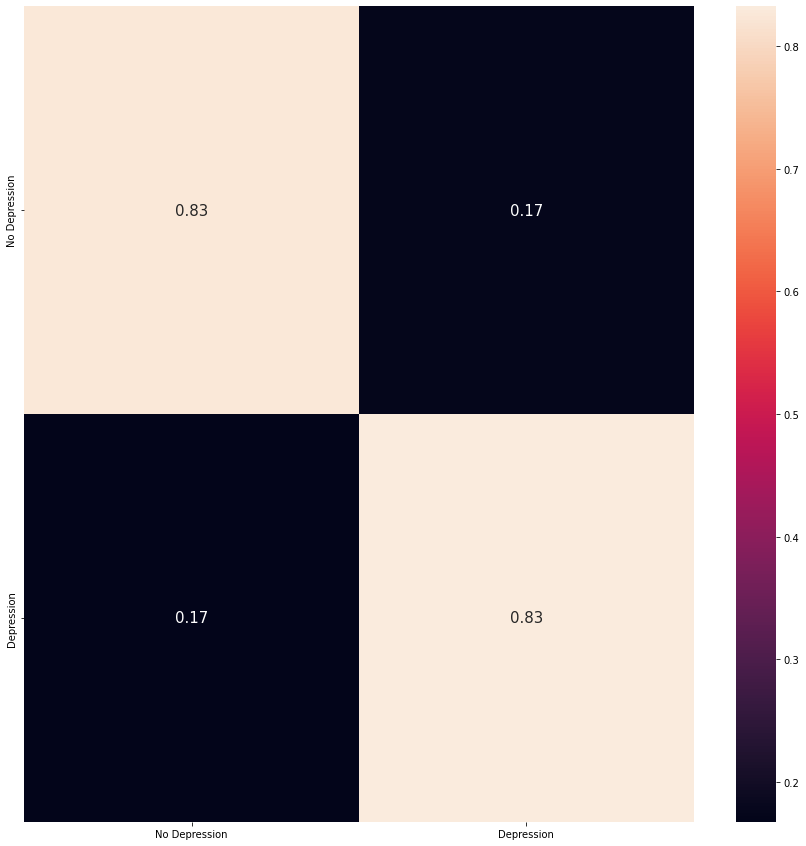

In [ ]:
matrix = confusion_matrix(y_test, np.around(y_pred, decimals=0))
conf_matrix = pd.DataFrame(matrix, index = ['No Depression','Depression'],columns = ['No Depression','Depression'])
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [ ]:
test = np.array(['Today is a precious gift'])
test_sequence = tokenizer.texts_to_sequences(test)
test_sequence = pad_sequences(test_sequence, maxlen=maxLength)
test_prediction = model2.predict(test_sequence)
if np.around(test_prediction, decimals=0)[0][0] == 1.0:
    print('The model predicted depressive/anxious language')
else:
    print("The model predicted other type of language")

1/1 [==============================] - 0s 52ms/step
The model predicted other type of language


Model 3 - Bidirectional LSTM layer

In [ ]:
model3 = Sequential()
model3.add(layers.Embedding(maxWords, 40))
model3.add(layers.Bidirectional(layers.LSTM(40,dropout=0.5)))
model3.add(layers.Dense(1,activation='sigmoid'))

model3.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

history = model3.fit(X_train, y_train, epochs=8,validation_data=(X_test, y_test))

Epoch 1/8
469/469 [==============================] - 217s 448ms/step - loss: 0.5919 - accuracy: 0.6761 - val_loss: 0.5119 - val_accuracy: 0.7514
Epoch 2/8
469/469 [==============================] - 200s 426ms/step - loss: 0.4224 - accuracy: 0.8052 - val_loss: 0.4428 - val_accuracy: 0.7940
Epoch 3/8
469/469 [==============================] - 200s 428ms/step - loss: 0.3437 - accuracy: 0.8497 - val_loss: 0.4144 - val_accuracy: 0.8144
Epoch 4/8
469/469 [==============================] - 202s 432ms/step - loss: 0.2984 - accuracy: 0.8701 - val_loss: 0.4005 - val_accuracy: 0.8240
Epoch 5/8
469/469 [==============================] - 202s 430ms/step - loss: 0.2633 - accuracy: 0.8915 - val_loss: 0.4152 - val_accuracy: 0.8234
Epoch 6/8
469/469 [==============================] - 202s 431ms/step - loss: 0.2416 - accuracy: 0.9016 - val_loss: 0.4138 - val_accuracy: 0.8332
Epoch 7/8
469/469 [==============================] - 201s 429ms/step - loss: 0.2210 - accuracy: 0.9101 - val_loss: 0.4028 - val_ac

In [ ]:
test_loss, test_acc = model3.evaluate(X_test,  y_test, verbose=2)
print('Model accuracy: ',test_acc)

157/157 - 11s - loss: 0.3887 - accuracy: 0.8350 - 11s/epoch - 71ms/step
Model accuracy:  0.8349999785423279


In [ ]:
y_pred = model3.predict(X_test)

157/157 [==============================] - 13s 77ms/step


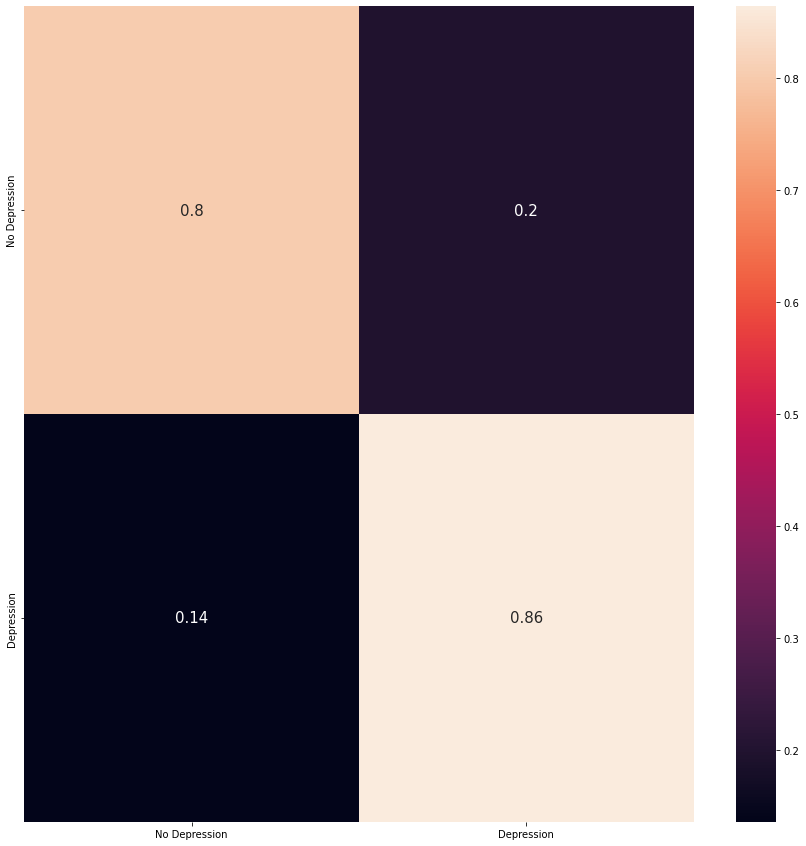

In [ ]:
matrix = confusion_matrix(y_test, np.around(y_pred, decimals=0))
conf_matrix = pd.DataFrame(matrix, index = ['No Depression','Depression'],columns = ['No Depression','Depression'])
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [ ]:
test = np.array(['I need a break from everything'])
test_sequence = tokenizer.texts_to_sequences(test)
test_sequence = pad_sequences(test_sequence, maxlen=maxLength)
test_prediction = model3.predict(test_sequence)
if np.around(test_prediction, decimals=0)[0][0] == 1.0:
    print('The model predicted depressive/anxious language')
else:
    print("The model predicted other type of language")

1/1 [==============================] - 0s 233ms/step
The model predicted depressive/anxious language


MODEL 4 - LSTM with CNN

In [ ]:
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
model4 = Sequential()
model4.add(layers.Embedding(maxWords, 40))
model4.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Dropout(0.2))

model4.add(LSTM(300))
model4.add(Dropout(0.2))
model4.add(Dense(1, activation='sigmoid'))

model4.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

history = model4.fit(X_train, y_train, epochs=7,validation_data=(X_test, y_test))

In [ ]:
test_loss, test_acc = model4.evaluate(X_test,  y_test, verbose=2)
print('Model accuracy: ',test_acc)

In [ ]:
y_pred = model4.predict(X_test)

In [ ]:
matrix = confusion_matrix(y_test, np.around(y_pred, decimals=0))
conf_matrix = pd.DataFrame(matrix, index = ['No Depression','Depression'],columns = ['No Depression','Depression'])
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [ ]:
test = np.array(['I have a good feeling about this week'])
test_sequence = tokenizer.texts_to_sequences(test)
test_sequence = pad_sequences(test_sequence, maxlen=maxLength)
test_prediction = model4.predict(test_sequence)
if np.around(test_prediction, decimals=0)[0][0] == 1.0:
    print('The model predicted depressive/anxious language')
else:
    print("The model predicted other type of language")

1/1 [==============================] - 0s 34ms/step
The model predicted other type of language
